In [1]:
# First, import the necessary databases

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math as math
import csv
import csv
import re
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/zandred/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/zandred/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/zandred/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Read csv file (censored)
df = pd.read_csv('sampledatafrane')

In [4]:
# Normilize the data
df.loc[:, 'as-set'] = df['as-set'].str.lower()
df.loc[:, 'descr'] = df['descr'].str.lower()
df.loc[:, 'members'] = df['members'].str.lower()
df.loc[:, 'mnt-by'] = df['mnt-by'].str.lower()

In [5]:
# Data conversion and 'days_since_modified' feature creation

# Convert 'last-modified' column to datetime 
df['last-modified'] = pd.to_datetime(df['last-modified'], format='%d-%m-%Y', errors='coerce')

# For dates not parsed yet, try to parse them with the second format
unparsed_dates = df['last-modified'].isna()
df.loc[unparsed_dates, 'last-modified'] = pd.to_datetime(df[unparsed_dates]['last-modified'], format='%d/%m/%Y', errors='coerce')

# Calculate 'days_since_modified' column
current_date = pd.to_datetime('today').normalize()
df.loc[:, 'days_since_modified'] = (current_date - df['last-modified']).dt.days

# Drop 'last-modified' column
df.drop(columns=['last-modified'], inplace=True)


In [6]:
# Drop rows with non-finite values
df = df.dropna(subset=['days_since_modified']).reset_index(drop=True)

# Convert the column to integers
df['days_since_modified'] = df['days_since_modified'].fillna(0).astype(int)

In [7]:
# Tokenization using Natural Language Toolkit
def process_as_set(as_set):
    # Check if the input is a string
    if not isinstance(as_set, str) or as_set.strip() == '':
        return []

    # Remove initial 'as-' from the as-set
    as_set = as_set.replace('as-', '', 1)
    
    # Tokenize the as-set
    tokenizer = RegexpTokenizer(r'\b\w+\b')
    tokens = tokenizer.tokenize(as_set.replace('-', ' '))
    
    return tokens

def process_mnt_by(mnt_by):
    # Check if the input is a string
    if not isinstance(mnt_by, str) or mnt_by.strip() == '':
        return []

    # Split the string on hyphens and spaces
    parts = re.split('-| ', mnt_by)

    # Remove unnecessary parts
    parts = [part for part in parts if part not in ['mnt', 'maint', 'lacnic']]

    # Join the parts back together and tokenize the result
    tokenizer = RegexpTokenizer(r'\b\w+\b')
    tokens = tokenizer.tokenize(' '.join(parts))
    
    return tokens

def process_text(text):
    # Check if the input is a string
    if not isinstance(text, str) or text.strip() == '':
        return []

    # Tokenize the text
    tokenizer = RegexpTokenizer(r'\b\w[\w-]*\b')
    tokens = tokenizer.tokenize(text)
    
    # Lowercase all words
    words = [word.lower() for word in tokens]

    # Handle specific cases
    words = ['as' if word in ['as', 'ases', 'ass'] else word for word in words]
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    stop_words.remove('as')  # Remove 'as' from the set of stop words
    words = [word for word in words if word not in stop_words]
    
    # Perform lemmatization
    wordnet = WordNetLemmatizer()
    words = [wordnet.lemmatize(word) if word != 'as' else 'as' for word in words]
    
    return words

def process_members(members):
    # Check if the input is a string
    if not isinstance(members, str) or members.strip() == '':
        return []

    # Split the string on commas
    tokens = members.split(',')

    # Remove leading and trailing whitespace from each token
    tokens = [token.strip() for token in tokens]
    
    return tokens




# Apply the function to the 'as-set' column
df['processed_as_set'] = df['as-set'].apply(process_as_set)

# Apply the function to the 'descr' column
df['processed_descr'] = df['descr'].apply(process_text)

# Apply the function to the 'mnt-by' column
df['processed_mnt_by'] = df['mnt-by'].apply(process_mnt_by)

# Apply the function to the 'members' column
df['processed_members'] = df['members'].apply(process_members)

In [8]:
# New list called new_order is initialized with column names in a specific order of columns in the DF
# Also it should be mentioned that 'mnt_by', 'descr' and 'members' are droppped 
new_order=['as-set', 'processed_as_set','processed_descr', 'processed_members','processed_mnt_by','AS_count', 'cone', 'days_since_modified','class']
df = df.reindex(columns=new_order)
# The column labels in the DF are renamed, 
df = df.rename(columns={'processed_mnt_by': 'mnt_by'})
df = df.rename(columns={'processed_descr': 'descr'})
df = df.rename(columns={'processed_members': 'members'})

In [9]:
# Create the 'only_asn' attribute
df['only_asn'] = 0
# Converting members to string type
df['members'] = df['members'].astype(str)

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # This line retrieves the value in the 'members' for the current row being processed and assigns it to the variable 
    members = row['members']
    # This line uses the re.findall() function from the re module to extract all the tokens from the members string
    tokens = re.findall(r'\b\w+\b', members) 
    # This line checks if all the tokens in the tokens list match the pattern r'^as\d+'. 
    # The pattern ^as\d+ looks for strings that start with 'as' followed by one or more digits. 
    is_only_asn = all(re.match(r'^as\d+', token.lower()) for token in tokens)
    
    # Set the 'only_asn' attribute based on the members
    if is_only_asn:
        df.at[index, 'only_asn'] = 1

In [10]:
# The 'relationship' attribute is created, where 0 value in cone is replaced by 0.0001
df['relationship'] = df['AS_count'] / df['cone'].replace(0, 0.0001)

In [11]:
# List of keywords for each attribute
descr_keywords = ['route', 'servers', 'isp', 'exchange', 'cix', 'ix', 'nix', 'upstreams', 'vodafone']
processed_as_set_keywords = ['rs', 'ix', 'decix', 'jaguar', 'amsix', 'lyonix', 'nix', 'cix', 'nixcz', 'upstreams', 'swissix', 'tele2', 'sfinx', 'uaeix']
mnt_by_keywords = ['decix', 'lir', 'jaguar']

# Initialize the 'keyword_present' field as 0 for all rows
df['keyword_present'] = 0

# Iterate over each row in the DF
for index, row in df.iterrows():
    # Check if any keyword is present in the 'descr' attribute
    for keyword in descr_keywords:
        if keyword in row['descr']:
            df.at[index, 'keyword_present'] = 1
            break  # Stop checking once a keyword is found

    # Check if any keyword is present in the 'processed_as_set' attribute
    for keyword in processed_as_set_keywords:
        if keyword in row['processed_as_set']:
            df.at[index, 'keyword_present'] = 1
            break  # Stop checking once a keyword is found

    # Check if any keyword is present in the 'mnt_by' attribute
    for keyword in mnt_by_keywords:
        if keyword in row['mnt_by']:
            df.at[index, 'keyword_present'] = 1
            break  # Stop checking once a keyword is found


In [12]:
# Count the total number of suspicious instances in DF
count = len(df[df['class'] == 'suspicious'])
print("The number of suspiciou instances is {}".format(count))

The number of suspiciou instances is 578


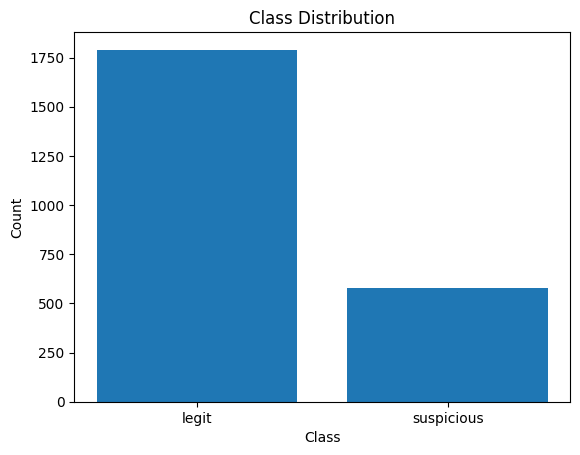

In [13]:
# Count the occurrences of each class
class_counts = df['class'].value_counts()

# Create a bar plot
plt.bar(class_counts.index, class_counts.values)

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

# Display the plot
plt.show()

In [14]:
print('Legit cases make', round(df['class'].value_counts()[0]/len(df) * 100,2), '% of the sample')
print('Suspicious cases make ', round(df['class'].value_counts()[1]/len(df) * 100,2), '% of the sample')

Legit cases make 75.59 % of the sample
Suspicious cases make  24.41 % of the sample


In [15]:
# Mapping dictionary
class_mapping = {'legit': 0, 'suspicious': 1}

# Convert 'class' column using mapping dictionary
df['class'] = df['class'].map(class_mapping)

In [16]:
columns_to_drop = ['processed_as_set', 'descr', 'members', 'mnt_by']
df = df.drop(columns_to_drop, axis=1)

In [17]:
# Reorder the DF
new_order=['as-set', 'AS_count', 'cone', 'days_since_modified', 'relationship', 'only_asn', 'keyword_present', 'class']
df = df.reindex(columns=new_order)

In [18]:
df

,as-set,AS_count,cone,days_since_modified,relationship,only_asn,keyword_present,class
0,as-set-link,3,5,596,0.600000,0,0,0
1,as-mobitex,1,1,2424,1.000000,1,0,1
2,as-active-fibre,1,1,311,1.000000,1,0,0
3,as-swcmcustomers,2,1,159,2.000000,0,0,1
4,as-60139,4,4,1546,1.000000,1,0,0
...,...,...,...,...,...,...,...,...
2363,as394127:as-all,1,1,1129,1.000000,1,0,0
2364,as-avmcau,1,1,243,1.000000,1,0,0
2365,as11996:as-cust1,9,7,745,1.285714,0,0,1
2366,as264646:as-tierranet,1,1,74,1.000000,1,0,0


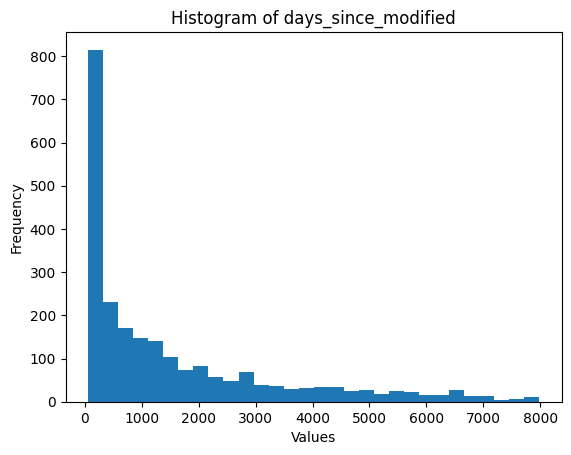

Shapiro-Wilk for days_since_modified:
Statistic: 0.7873
p-value: 0.0000

D'Agostino-Pearson for days_since_modified:
Statistic: 584.1487
p-value: 0.0000

Anderson-Darling for days_since_modified:
Statistic: 175.0119
Critical Values: [0.575 0.655 0.786 0.916 1.09 ]
Significance Levels: [15.  10.   5.   2.5  1. ]



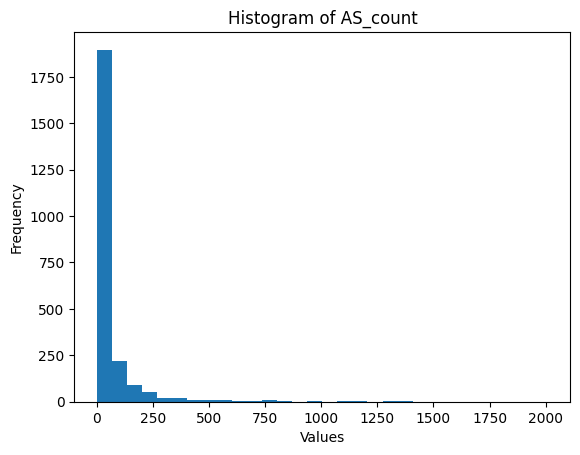

Shapiro-Wilk for AS_count:
Statistic: 0.4003
p-value: 0.0000

D'Agostino-Pearson for AS_count:
Statistic: 2657.2197
p-value: 0.0000

Anderson-Darling for AS_count:
Statistic: 452.4617
Critical Values: [0.575 0.655 0.786 0.916 1.09 ]
Significance Levels: [15.  10.   5.   2.5  1. ]



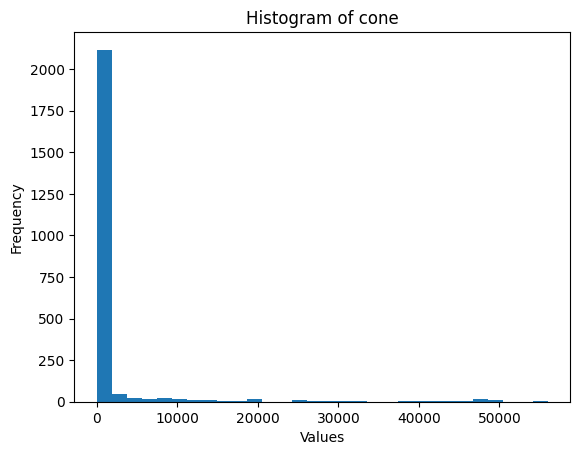

Shapiro-Wilk for cone:
Statistic: 0.2848
p-value: 0.0000

D'Agostino-Pearson for cone:
Statistic: 2297.3188
p-value: 0.0000

Anderson-Darling for cone:
Statistic: 692.9079
Critical Values: [0.575 0.655 0.786 0.916 1.09 ]
Significance Levels: [15.  10.   5.   2.5  1. ]



In [19]:
# Select the features of interest from the DF
features = ['days_since_modified', 'AS_count', 'cone',]
data = df[features]

# Loop over each feature and check the distribution type
for feature in features:
    # Extract the data for the current feature
    feature_data = data[feature]
    # Plot a histogram
    plt.hist(feature_data, bins=30)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {feature}')
    plt.show()

    # Perform normality tests
    normality_tests = {
        'Shapiro-Wilk': stats.shapiro,
        'D\'Agostino-Pearson': stats.normaltest,
        'Anderson-Darling': stats.anderson
    }

    for test_name, test_func in normality_tests.items():
        if test_name == 'Anderson-Darling':
            statistic, critical_values, significance_levels = test_func(feature_data)
            print(f'{test_name} for {feature}:')
            print(f'Statistic: {statistic:.4f}')
            print(f'Critical Values: {critical_values}')
            print(f'Significance Levels: {significance_levels}')
        else:
            statistic, p_value = test_func(feature_data)
            print(f'{test_name} for {feature}:')
            print(f'Statistic: {statistic:.4f}')
            print(f'p-value: {p_value:.4f}')
        print('')



In [20]:
# Export the DF
df.to_csv('final_model.csv', index=False)